# Forest Fire Classification model 

### This notebook makes the use of the `Active Fire Data` for India in the year 2021 provided by `NASA`.
- You can find several other datasets provided by  [here](https://www.earthdata.nasa.gov/)

### Let's first analyse the dataset

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

In [3]:
df=pd.read_csv("modis_india_2021.csv")

In [4]:
df

,index,latitude,longitude,brightness,scan,track,acq_time,satellite,confidence,bright_t31,frp,daynight,type
0,13,26.6395,79.4841,311.8,1.6,1.2,548,Terra,72,289.7,18.3,D,2
1,14,26.6423,79.4749,309.0,1.6,1.2,548,Terra,64,289.7,15.8,D,2
2,15,26.6394,79.4905,304.3,1.6,1.2,548,Terra,51,289.9,9.8,D,2
3,21,18.6875,73.0387,315.7,1.0,1.0,550,Terra,0,300.6,7.3,D,2
4,50,23.7779,86.3951,314.6,1.3,1.1,720,Aqua,66,302.5,10.9,D,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
12237,111262,21.1066,72.6336,307.9,1.5,1.2,1703,Terra,73,290.5,16.1,N,2
12238,111263,19.1224,76.7451,303.2,1.0,1.0,1703,Terra,54,288.0,6.5,N,0
12239,111264,19.2367,76.9620,304.1,1.0,1.0,1703,Terra,59,288.2,7.2,N,0
12240,111265,23.7817,86.3960,306.2,1.2,1.1,1954,Aqua,65,287.8,10.8,N,2


### The columns represent the following: 
- `latitude`: Latitude of the fire pixel detected by the satellite *(degrees)*
- `longitude`: Longitude of the fire pixel detected by the satellite *(degrees)*
- `brightness`: Brightness temperature of the fire pixel *(in K)*
- `scan`: Area of a MODIS pixel at the Earth’s surface *(Along-scan: ΔS)*
- `track`: Area of a MODIS pixel at the Earth’s surface *(Along-track: ΔT)*
- `acq_time`: Time at which the fire was detected
- `satellite`: Satellite used to detect the fire. Either Terra(T) or Aqua(A)
- `instrument`: MODIS
- `confidence`: Detection confidence *(range 0-100)*
- `bright_t31`:  Band 31 brightness temperature of the pixel *(in K)*
- `frp`: Fire radiative power *(in MW- megawatts)*
- `daynight`: Detected during the day or night. Either Day(D) or Night(N) 
- `type`: Inferred hot spot type: 
         - 0= presumed vegetation fire 
         - 1= active volcano
         - 2= other static land source
         - 3= offshore

### In this notebook, we will be building models to predict the type of forest fire detected by MODIS.

In [5]:
print(df['satellite'].value_counts())
print(df['daynight'].value_counts())
print(df['type'].value_counts())

satellite
Aqua     8400
Terra    3842
Name: count, dtype: int64
daynight
D    10259
N     1983
Name: count, dtype: int64
type
0    7915
2    4314
3      13
Name: count, dtype: int64


> We can see that: 
- There is a huge imbalance of classes in the `type` column for number `3`. Hence we can drop it.

In [6]:

for i in df.index:
    if df['type'][i]==3: 
      df.drop([i],inplace=True)
df.reset_index(inplace = True)


### Handling categorical values
- Since we have 2 values (Terra and Aqua) for satellite, we will be using a binary encoder

In [7]:
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=['satellite'])
df = encoder.fit_transform(df)
encoder = ce.BinaryEncoder(cols=['daynight'])
df = encoder.fit_transform(df)

In [8]:
df.head()

,level_0,index,latitude,longitude,brightness,scan,track,acq_time,satellite_0,satellite_1,confidence,bright_t31,frp,daynight_0,daynight_1,type
0,0,13,26.6395,79.4841,311.8,1.6,1.2,548,0,1,72,289.7,18.3,0,1,2
1,1,14,26.6423,79.4749,309.0,1.6,1.2,548,0,1,64,289.7,15.8,0,1,2
2,2,15,26.6394,79.4905,304.3,1.6,1.2,548,0,1,51,289.9,9.8,0,1,2
3,3,21,18.6875,73.0387,315.7,1.0,1.0,550,0,1,0,300.6,7.3,0,1,2
4,4,50,23.7779,86.3951,314.6,1.3,1.1,720,1,0,66,302.5,10.9,0,1,2


- Here `satellite_0` is for Aqua while `satellite_1` is for Terra
- And `daynight_0` is for Day while `daynight_1` is for Night
- Hence we can remove one of them

In [9]:
df=df.drop(['satellite_1','daynight_1'], axis=1)

### Handling the time column `acq_time`
- Since it's in the format HHMM, we will only extract the hours part of the time, minutes won't be relevant for our model. 
- using floor division we removed last 2 digits that represented the minutes

In [10]:
df['acq_time'] = df['acq_time']//100 
df.head()
    

,level_0,index,latitude,longitude,brightness,scan,track,acq_time,satellite_0,confidence,bright_t31,frp,daynight_0,type
0,0,13,26.6395,79.4841,311.8,1.6,1.2,5,0,72,289.7,18.3,0,2
1,1,14,26.6423,79.4749,309.0,1.6,1.2,5,0,64,289.7,15.8,0,2
2,2,15,26.6394,79.4905,304.3,1.6,1.2,5,0,51,289.9,9.8,0,2
3,3,21,18.6875,73.0387,315.7,1.0,1.0,5,0,0,300.6,7.3,0,2
4,4,50,23.7779,86.3951,314.6,1.3,1.1,7,1,66,302.5,10.9,0,2


### Feature Selection and finding the correlation

- We are using `stratified shuffle split` since our dataset contains unbalanced classes for the `type` column. 

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit
target='type'

feature_cols = [x for x in df.columns if x != target]

strat_shuff_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

# Get the index values from the generator
train_idx, test_idx = next(strat_shuff_split.split(df[feature_cols], df[target]))

# Create the data sets
X_train = df.loc[train_idx, feature_cols]
y_train = df.loc[train_idx, target]
X_test = df.loc[test_idx, feature_cols]
y_test = df.loc[test_idx, target]

- Now that we have split the model, we will start with the feature selection

<Axes: >

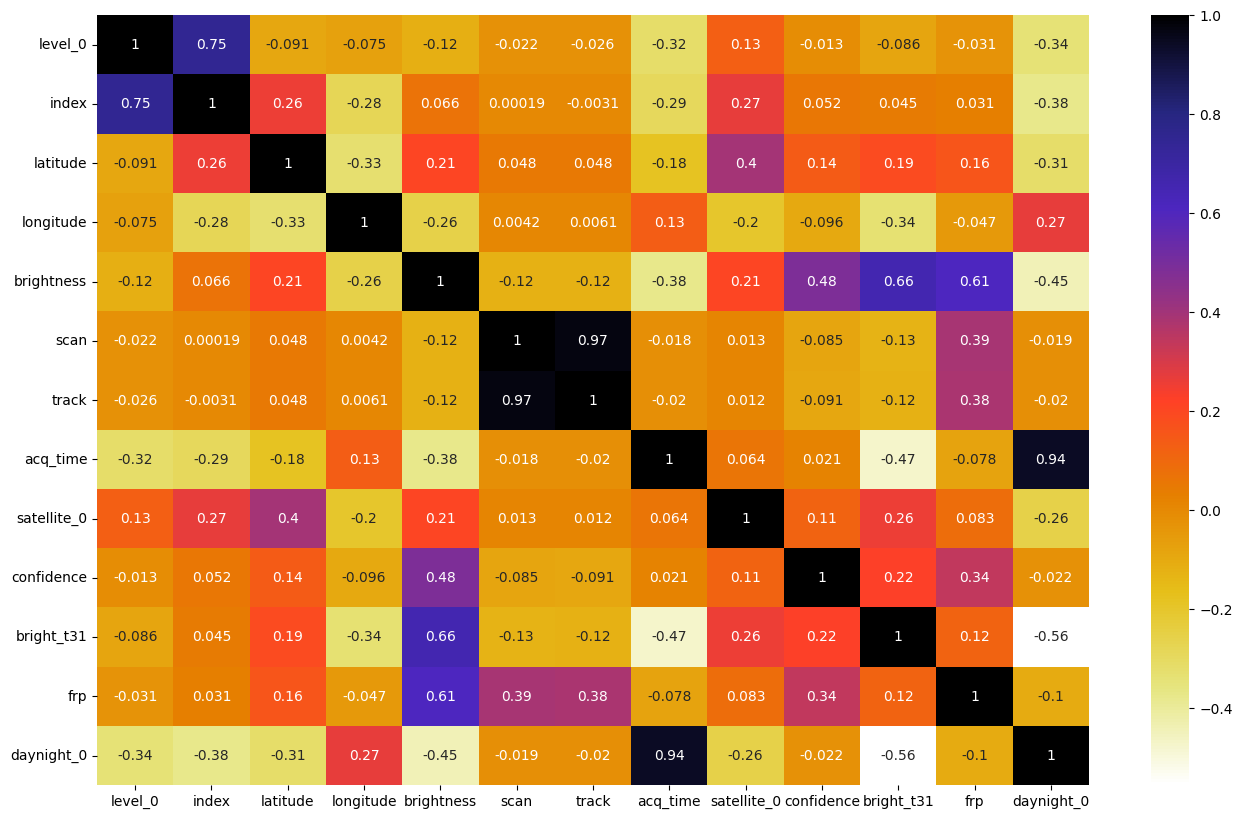

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize=(16,10))
cor=X_train.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.CMRmap_r)

> We will define a function to identify the highly correlated features to remove them

In [13]:
def correlation(dataset, threshold):
     col_corr = set() # Set of all the names of correlated columns
     corr_matrix = dataset.corr()
     for i in range(len(corr_matrix.columns)):
         for j in range(i):
             if (corr_matrix.iloc[i,j])>threshold: # we are interested in absolute coeff value
                 colname= corr_matrix.columns[i] # getting the name of column
                 col_corr.add(colname) 
     return col_corr


In [14]:
features= correlation(X_train,0.9)
print(set(features))

{'daynight_0', 'track'}


> We can now drop the features `track` and `daynight_0` 

In [15]:
X_train=X_train.drop(['track','daynight_0'],axis=1)

### Applying the same to test data

In [16]:
X_test=X_test.drop(['track','daynight_0'],axis=1)

## Applying Machine Learning Models
- We will be applying 3 models and comparing it with each other: 
 - Logistic Regression 
 - K Nearest Neighbours 
 - XG Boost

### Logistic Regression

We are keeping an `l2 regularization` since it has comparatively lesser computational complexity 

In [17]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='liblinear', penalty='l2').fit(X_train, y_train)

> Plotting the confusion matrix 

In [18]:
predictions=lr.predict(X_test)

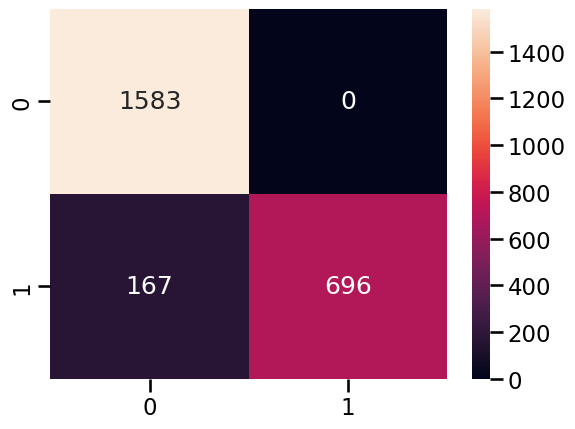

In [19]:
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
sns.set_context('talk')
cm = confusion_matrix(y_test, predictions)
ax = sns.heatmap(cm, annot=True, fmt='d')

**The confusion matrix for logistic regression indicates that all the type 0s are predicted correctly, none of them are predicted as 1, while a lot of type 2s (depicted as 1 in the confusion matrix) are predicted as 0.**

In [20]:
print(classification_report(y_test, predictions))
print('Accuracy score: ', round(accuracy_score(y_test, predictions), 2))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      1583
           2       1.00      0.81      0.89       863

    accuracy                           0.93      2446
   macro avg       0.95      0.90      0.92      2446
weighted avg       0.94      0.93      0.93      2446

Accuracy score:  0.93


Therefore with `logistic regression` we get an accuracy of **93%**

## K Nearest Neighbour

In [21]:
from sklearn.neighbors import KNeighborsClassifier


> Checking the accuracy for different values of K to find the best one.

In [22]:
accuracy_rate=[]

for i in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn = knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    score=round(accuracy_score(y_test, y_pred), 2)
    accuracy_rate.append(score.mean())

Text(0, 0.5, 'Accuracy')

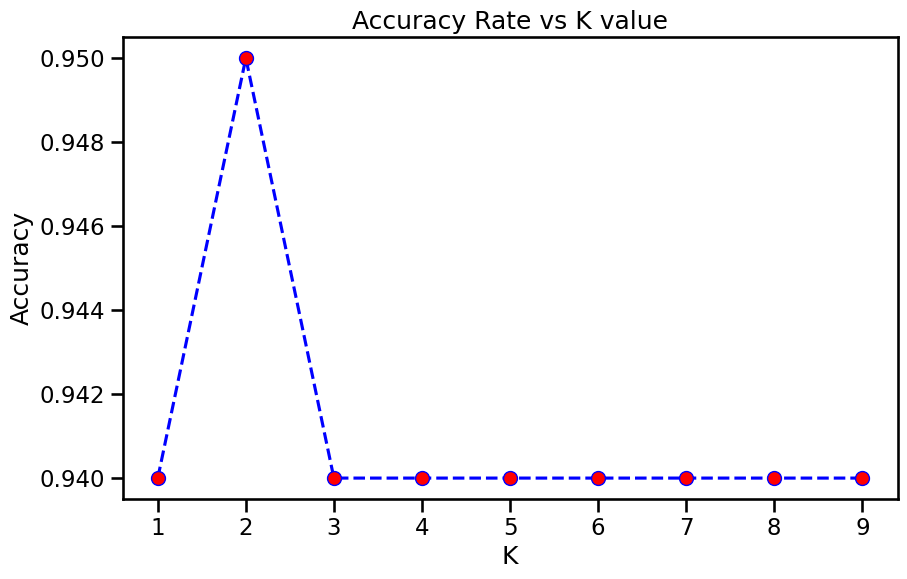

In [23]:
plt.figure(figsize=(10,6))
plt.plot(range(1,10),accuracy_rate,color='blue',linestyle='dashed',marker='o',markerfacecolor='red',markersize=10)
plt.title('Accuracy Rate vs K value')
plt.xlabel('K')
plt.ylabel('Accuracy')

As shown in the graph. K=2 gives us the best accuracy.

In [24]:
# Estimate KNN model and report outcomes
knn = KNeighborsClassifier(n_neighbors=2)
knn = knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
# Preciision, recall, f-score from the multi-class support function
print(classification_report(y_test, y_pred))
print('Accuracy score: ', round(accuracy_score(y_test, y_pred), 2))

              precision    recall  f1-score   support

           0       0.93      0.98      0.96      1583
           2       0.97      0.87      0.92       863

    accuracy                           0.95      2446
   macro avg       0.95      0.93      0.94      2446
weighted avg       0.95      0.95      0.94      2446

Accuracy score:  0.95


> Plotting the confusion matrix for KNN

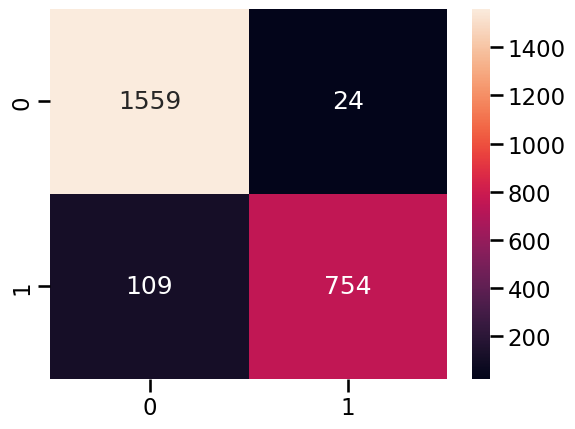

In [25]:
sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

**Even though the accuracy for KNN (95%) is higher than that for Logistic Regression (93%), KNN model predicts a fair number of type 0s incorrectly.**

### XG BOOST

- Using a list of number of trees we will iterate through each and select the one that gives us the least error. 

In [26]:
### BEGIN SOLUTION
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

error_list = list()

# Iterate through various possibilities for number of trees
tree_list = [15, 25, 50, 100, 200, 400]
for n_trees in tree_list:
    
    # Initialize the gradient boost classifier
    GBC = GradientBoostingClassifier(n_estimators=n_trees, random_state=42)

    # Fit the model
    print(f'Fitting model with {n_trees} trees')
    GBC.fit(X_train.values, y_train.values)
    y_pred = GBC.predict(X_test)

    # Get the error
    error = 1.0 - accuracy_score(y_test, y_pred)
    
    # Store it
    error_list.append(pd.Series({'n_trees': n_trees, 'error': error}))

error_df = pd.concat(error_list, axis=1).T.set_index('n_trees')

error_df

Fitting model with 15 trees


c:\Users\sayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Fitting model with 25 trees


c:\Users\sayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Fitting model with 50 trees


c:\Users\sayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Fitting model with 100 trees


c:\Users\sayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Fitting model with 200 trees


c:\Users\sayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


Fitting model with 400 trees


c:\Users\sayan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but GradientBoostingClassifier was fitted without feature names
  warnings.warn(


,error
n_trees,
15.0,0.023712
25.0,0.023303
50.0,0.021259
100.0,0.016762
200.0,0.015536
400.0,0.015944


- Plotting a graph to analyse the error rate for every number of trees.

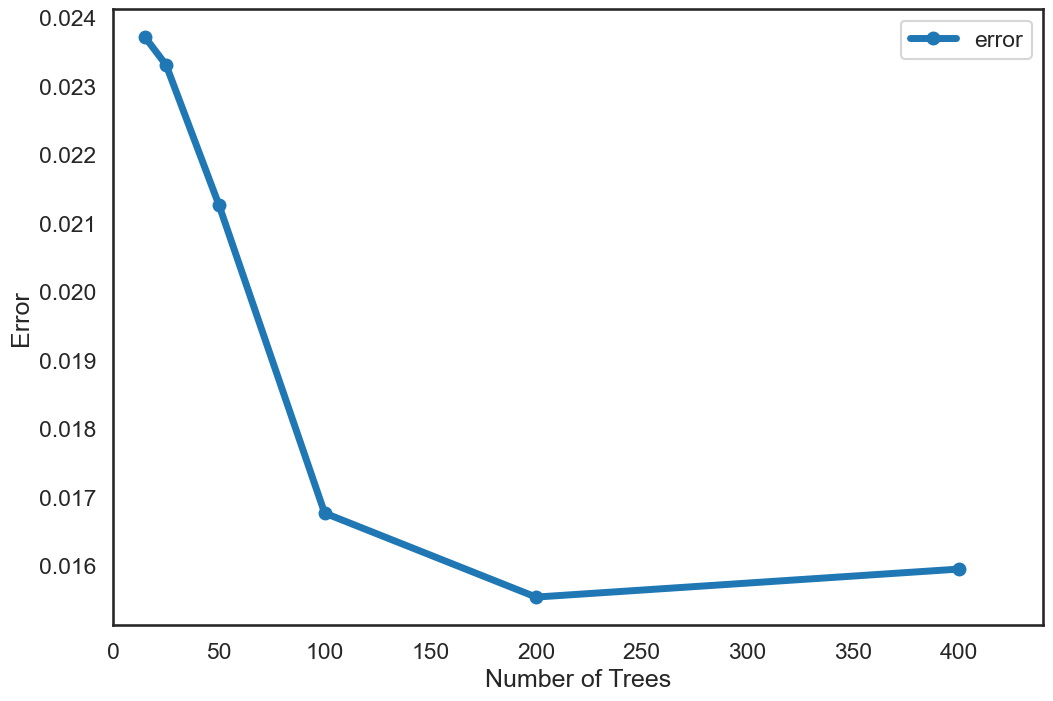

In [27]:
sns.set_context('talk')
sns.set_style('white')

# Create the plot
ax = error_df.plot(marker='o', figsize=(12, 8), linewidth=5)

# Set parameters
ax.set(xlabel='Number of Trees', ylabel='Error')
ax.set_xlim(0, max(error_df.index)*1.1);
### END SOLUTION

- As shown in the graph, no. of trees=200 gives us the least error

> We can also make the use of **GridSearchCV** library of Sklearn to find the best estimator.

In [28]:
### BEGIN SOLUTION
from sklearn.model_selection import GridSearchCV

# The parameters to be fit
param_grid = {'n_estimators': tree_list,
              'learning_rate': [0.1, 0.01, 0.001, 0.0001],
              'subsample': [1.0, 0.5],
              'max_features': [1, 2, 3, 4]}

# The grid search object
GV_GBC = GridSearchCV(GradientBoostingClassifier(random_state=42), 
                      param_grid=param_grid, 
                      scoring='accuracy',
                      n_jobs=-1)

# Do the grid search
GV_GBC = GV_GBC.fit(X_train, y_train)

In [29]:
GV_GBC.best_estimator_

GradientBoostingClassifier(max_features=4, n_estimators=200, random_state=42)

In [30]:
from sklearn.metrics import classification_report

y_pred = GV_GBC.predict(X_test)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1611
           2       0.96      0.99      0.97       835

    accuracy                           0.98      2446
   macro avg       0.98      0.98      0.98      2446
weighted avg       0.98      0.98      0.98      2446



**We can get an accuracy of 98% with XGBOOST, higher than the rest of the models.**

In [31]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.982011447260834

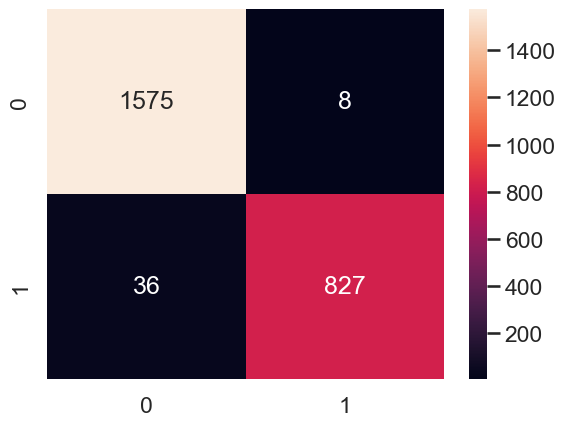

In [32]:
from sklearn.metrics import confusion_matrix

sns.set_context('talk')
cm = confusion_matrix(y_test, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d')

> Confusion matrix shows least amount values predicted incorrectly.

In [37]:
import pickle

# Assuming y_test and y_pred are already computed
results = {'y_test': y_test, 'y_pred': y_pred}

# Save the results to a pickle file
with open('results.pkl', 'wb') as file:
    pickle.dump(results, file)


In [38]:
with open('results.pkl', 'rb') as file:
    loaded_results = pickle.load(file)

y_test_loaded = loaded_results['y_test']
y_pred_loaded = loaded_results['y_pred']

## Conclusion: 
- Logistic Regression: 93% 
- KNN: 95%
- XGBOOST: 98% 

### Hence the best Algorithm for the prediction of the type of forest fire detected by MODIS satellite will be ***XGBOOST*** 